In [2]:
import pandas as pd
import random
import numpy as np
import string
import re
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.ensemble import RandomForestClassifier
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hammam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hammam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
tweets = pd.read_csv('D:/personal project/twitter_sentiment_analysis/datasets/tweet_aug_2.csv')
tweets

,Unnamed: 0,sentimen,tweet
0,0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,1,negatif,bercakap prabowo indonesia belum dihargai bang...
2,2,netral,batuan langka tasbih jokowi hadiah dari habib ...
3,3,netral,batuan langka tasbih jokowi bakat dari habib l...
4,4,netral,di era jokowi ekonomi indonesia semakin baik m...
...,...,...,...
3625,3625,netral,mari bangkit bangsa dengan mendukung perekonom...
3626,3626,netral,bantu majukan perekonomian bangsa bersama bapa...
3627,3627,netral,bantu majukan perekonomian bangsa bersama bapa...
3628,3628,netral,bapak jokowi mengubah cara pandang ekonomi kin...


In [4]:
del tweets[tweets.columns[0]]

In [5]:
tweets

,sentimen,tweet
0,negatif,kata prabowo indonesia tidak dihargai bangsa a...
1,negatif,bercakap prabowo indonesia belum dihargai bang...
2,netral,batuan langka tasbih jokowi hadiah dari habib ...
3,netral,batuan langka tasbih jokowi bakat dari habib l...
4,netral,di era jokowi ekonomi indonesia semakin baik m...
...,...,...
3625,netral,mari bangkit bangsa dengan mendukung perekonom...
3626,netral,bantu majukan perekonomian bangsa bersama bapa...
3627,netral,bantu majukan perekonomian bangsa bersama bapa...
3628,netral,bapak jokowi mengubah cara pandang ekonomi kin...


In [6]:
tweets['sentimen'].value_counts()

sentimen
positif    1224
netral     1214
negatif    1192
Name: count, dtype: int64

In [7]:
mapping = {
    "negatif": 0,
    "netral": 1,
    "positif": 2,
}

tweets['sentimen'] = [mapping[label] for label in tweets['sentimen']]
tweets

,sentimen,tweet
0,0,kata prabowo indonesia tidak dihargai bangsa a...
1,0,bercakap prabowo indonesia belum dihargai bang...
2,1,batuan langka tasbih jokowi hadiah dari habib ...
3,1,batuan langka tasbih jokowi bakat dari habib l...
4,1,di era jokowi ekonomi indonesia semakin baik m...
...,...,...
3625,1,mari bangkit bangsa dengan mendukung perekonom...
3626,1,bantu majukan perekonomian bangsa bersama bapa...
3627,1,bantu majukan perekonomian bangsa bersama bapa...
3628,1,bapak jokowi mengubah cara pandang ekonomi kin...


# Split Data

In [8]:
tweets['tweet'] = tweets['tweet'].astype(str)
tweets['tweet'] = tweets['tweet'].fillna('')

In [9]:
features = tweets['tweet']
target = tweets['sentimen']

In [10]:
X = features
Y = target
# display(X)
# display(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [12]:
train_tweet, test_tweet, train_sentimen, test_sentimen = train_test_split(tweets['tweet'].to_numpy(), tweets['sentimen'].to_numpy(), test_size=0.2, random_state=0)

In [13]:
round(sum([len(i.split()) for i in train_tweet])/len(train_tweet))

24

In [14]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 24 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length)

In [15]:
text_vectorizer

In [16]:
text_vectorizer.adapt(X_train.to_numpy())

In [17]:
sample_setence = X_train[0]
text_vectorizer([sample_setence])

<tf.Tensor: shape=(1, 24), dtype=int64, numpy=
array([[ 171,    5,   11,    6,  421,   85,  752,  405,   13,  208,  451,
        7237, 6192,   44,   72, 2469,    0,    0,    0,    0,    0,    0,
           0,    0]], dtype=int64)>

In [18]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:10] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-10:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 7496
Top 5 most common words: ['', '[UNK]', 'ekonomi', 'jokowi', 'dan', 'prabowo', 'tidak', 'bapak', 'di', 'gaji']
Bottom 5 least common words: ['absolut', 'abshar', 'abg', 'abdul', 'abdalla', 'abai', 'abah', 'abadi', 'aaamiin', 'aa']


# Create Embedding

In [19]:
tf.random.set_seed(42)

embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=64,
    embeddings_initializer="uniform",
    input_length=max_length,
    name="embedding_1")

embedding

In [20]:
# Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
bapak prabowo sandi sangat benarbenar kepiawian segai daftarpresidenamerikaserikat negri inibeliau meyakinkan bahwa akan memperhatikan gizi dan perekonomian rakyat serta beroleh indonesia berdaulat di kancah international serta menggiring indonesia adil makmur      

Embedded version:


<tf.Tensor: shape=(1, 24, 64), dtype=float32, numpy=
array([[[ 0.04470244,  0.04539755, -0.04882209, ..., -0.01860004,
          0.0346823 ,  0.02891826],
        [ 0.02989456, -0.02106887,  0.01705411, ..., -0.03186919,
          0.03569784, -0.00790545],
        [ 0.01681026, -0.03258876, -0.03719231, ...,  0.03846726,
         -0.00712977, -0.01606334],
        ...,
        [-0.00951727, -0.04279606,  0.03388682, ..., -0.04865793,
         -0.02926923,  0.04173649],
        [ 0.00492692,  0.03965611, -0.0488975 , ..., -0.02761716,
         -0.03577515, -0.04258428],
        [-0.00731359, -0.03442873, -0.03290925, ...,  0.0103706 ,
          0.03506299,  0.02330022]]], dtype=float32)>

In [21]:
def calculate_results(y_true, y_pred):

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Model 1

In [22]:
def model1():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(32)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer, name="model_1_LSTM")
  return model

In [23]:
lstm1 = model1()
lstm1.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm1.summary()

Model: "model_1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 out_layer (Dense)           (None, 3)                 99        
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                      

In [24]:
lstm1_history = lstm1.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20


12/12 [==============================] - 13s 293ms/step - loss: 1.0910 - accuracy: 0.4308 - val_loss: 1.0805 - val_accuracy: 0.4421
Epoch 2/20
12/12 [==============================] - 1s 83ms/step - loss: 1.0611 - accuracy: 0.5348 - val_loss: 1.0449 - val_accuracy: 0.5055
Epoch 3/20
12/12 [==============================] - 1s 81ms/step - loss: 1.0008 - accuracy: 0.5930 - val_loss: 0.9997 - val_accuracy: 0.5110
Epoch 4/20
12/12 [==============================] - 1s 88ms/step - loss: 0.8638 - accuracy: 0.6763 - val_loss: 0.8344 - val_accuracy: 0.6708
Epoch 5/20
12/12 [==============================] - 1s 85ms/step - loss: 0.5967 - accuracy: 0.8051 - val_loss: 0.7973 - val_accuracy: 0.6846
Epoch 6/20
12/12 [==============================] - 1s 91ms/step - loss: 0.3718 - accuracy: 0.8809 - val_loss: 0.6463 - val_accuracy: 0.7769
Epoch 7/20
12/12 [==============================] - 1s 85ms/step - loss: 0.2126 - accuracy: 0.9421 - val_loss: 0.5272 - val_accuracy: 0.8264
Epoch 8/20
12/12 [====

In [25]:
test_sentimen

array([1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2,
       0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2,
       0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 0,
       1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       2, 0, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0, 1,
       0, 2, 0, 1, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 2,
       0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2,
       0, 0, 0, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 1,
       0, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 1, 0,
       1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0,
       2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 1, 2, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 1, 2, 0, 2, 0, 0, 1, 0, 1,
       0, 2, 2, 2, 1, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0,

In [26]:
# Make predictions on the validation dataset
model_1_pred_probs = lstm1.predict(test_tweet)
display(model_1_pred_probs.shape, model_1_pred_probs[:10]) # view the first 10

model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds = np.argmax(model_1_preds, axis=1)

# Calculate LSTM model results
model_1_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_1_preds)
display(model_1_results)

display(tf.squeeze(tf.round(lstm1.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 3s 9ms/step


(726, 3)

array([[0.03540388, 0.02432854, 0.9402675 ],
       [0.00396541, 0.9915201 , 0.00451446],
       [0.9926973 , 0.00219931, 0.00510332],
       [0.00241562, 0.99540174, 0.00218271],
       [0.00265428, 0.9949561 , 0.00238964],
       [0.00203226, 0.00230827, 0.9956594 ],
       [0.00313506, 0.9937039 , 0.00316108],
       [0.00191769, 0.99644667, 0.00163563],
       [0.00738175, 0.00488055, 0.98773766],
       [0.0040208 , 0.99240124, 0.00357799]], dtype=float32)

{'accuracy': 84.9862258953168,
 'precision': 0.8528632317913489,
 'recall': 0.849862258953168,
 'f1': 0.8497570794895335}

1/1 [==============================] - 0s 57ms/step


array([0., 1., 0.], dtype=float32)

In [27]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm1.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 51ms/step


In [28]:
predicted_sentiment

[array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([0., 1., 0.], dtype=float32),
 array([0., 0., 1.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 

In [29]:
predicted_dataframe = pd.DataFrame(columns=['sentimen', 'predicted_sentimen', 'tweet'])

In [30]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,2,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi dan raja salman sepakat tingkatkan kerj...
2,0,0,kala tax amnesty hari prabowo sama sandiaga un...
3,1,1,gimana nih apa atas gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dr binatang minimal juta tu...
...,...,...,...
721,0,0,bakda itu maine nyerocos tentang gurubesar sum...
722,1,1,asosiasi pengusaha bumiputera nusantara se ind...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang aids bedakan startup kayak monetizing...


# Model 2

In [31]:
def model2():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [32]:
lstm2 = model2()
lstm2.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                             

In [33]:
lstm2_history = lstm2.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20


12/12 [==============================] - 14s 328ms/step - loss: 1.0658 - accuracy: 0.6150 - val_loss: 1.0186 - val_accuracy: 0.6405
Epoch 2/20
12/12 [==============================] - 2s 156ms/step - loss: 0.8006 - accuracy: 0.7813 - val_loss: 0.6231 - val_accuracy: 0.7755
Epoch 3/20
12/12 [==============================] - 1s 119ms/step - loss: 0.1966 - accuracy: 0.9432 - val_loss: 0.8395 - val_accuracy: 0.8196
Epoch 4/20
12/12 [==============================] - 1s 112ms/step - loss: 0.0474 - accuracy: 0.9866 - val_loss: 0.7527 - val_accuracy: 0.8333
Epoch 5/20
12/12 [==============================] - 1s 114ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.7397 - val_accuracy: 0.8347
Epoch 6/20
12/12 [==============================] - 1s 116ms/step - loss: 0.0290 - accuracy: 0.9917 - val_loss: 0.7950 - val_accuracy: 0.8347
Epoch 7/20
12/12 [==============================] - 1s 115ms/step - loss: 0.0252 - accuracy: 0.9921 - val_loss: 0.7207 - val_accuracy: 0.8609
Epoch 8/20
12/12

In [34]:
# Make predictions on the validation dataset
model_2_pred_probs = lstm2.predict(test_tweet)
display(model_2_pred_probs.shape, model_2_pred_probs[:10]) # view the first 10

model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds = np.argmax(model_2_preds, axis=1)

# Calculate LSTM model results
model_2_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_2_preds)
display(model_2_results)

display(tf.squeeze(tf.round(lstm2.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 3s 14ms/step


(726, 3)

array([[7.5881029e-03, 3.9474316e-02, 9.5293754e-01],
       [5.4482389e-05, 9.9958771e-01, 3.5786335e-04],
       [9.9955589e-01, 2.8312200e-04, 1.6095708e-04],
       [1.2031130e-05, 9.9995160e-01, 3.6312402e-05],
       [3.3190618e-03, 9.9356776e-01, 3.1131685e-03],
       [1.9449488e-05, 7.8948287e-05, 9.9990153e-01],
       [6.8899267e-06, 9.9995065e-01, 4.2453459e-05],
       [1.8361759e-06, 9.9999166e-01, 6.5756744e-06],
       [2.7493629e-04, 1.8497364e-04, 9.9954009e-01],
       [4.6916070e-06, 9.9998081e-01, 1.4527746e-05]], dtype=float32)

{'accuracy': 85.53719008264463,
 'precision': 0.8592739365768106,
 'recall': 0.8553719008264463,
 'f1': 0.8554935934452543}

1/1 [==============================] - 0s 39ms/step


array([0., 1., 0.], dtype=float32)

In [35]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm2.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 450ms/step


In [36]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe[:25])

,sentimen,predicted_sentimen,tweet
0,1,2,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi dan raja salman sepakat tingkatkan kerj...
2,0,0,kala tax amnesty hari prabowo sama sandiaga un...
3,1,1,gimana nih apa atas gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dr binatang minimal juta tu...
5,2,2,uang gaji kami prabowo sandiuno tidak akan kam...
6,1,1,capres jokowi nasabah usaha mikro di pesantren...
7,1,1,demokrat minta prabowo hargai bantuan presiden...
8,1,2,orang baik jelas islamnya baju putih kekompaka...
9,1,1,ps bolakbalik menyinggung bertanya deindustria...


# Model 3

In [37]:
def model3():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(128,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [38]:
lstm3 = model3()
lstm3.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                           

In [39]:
lstm3_history = lstm3.fit(X_train, np.float32(Y_train),
                          epochs=20,
                          batch_size=256,
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20


12/12 [==============================] - 15s 332ms/step - loss: 1.0275 - accuracy: 0.6388 - val_loss: 0.9080 - val_accuracy: 0.6515
Epoch 2/20
12/12 [==============================] - 1s 113ms/step - loss: 0.5364 - accuracy: 0.8278 - val_loss: 0.6007 - val_accuracy: 0.8058
Epoch 3/20
12/12 [==============================] - 1s 113ms/step - loss: 0.0927 - accuracy: 0.9745 - val_loss: 1.3132 - val_accuracy: 0.8264
Epoch 4/20
12/12 [==============================] - 1s 111ms/step - loss: 0.0347 - accuracy: 0.9914 - val_loss: 1.3949 - val_accuracy: 0.8209
Epoch 5/20
12/12 [==============================] - 1s 114ms/step - loss: 0.0182 - accuracy: 0.9948 - val_loss: 1.2333 - val_accuracy: 0.8499
Epoch 6/20
12/12 [==============================] - 2s 154ms/step - loss: 0.0346 - accuracy: 0.9910 - val_loss: 1.0453 - val_accuracy: 0.8567
Epoch 7/20
12/12 [==============================] - 2s 153ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.9441 - val_accuracy: 0.8540
Epoch 8/20
12/12

In [40]:
# Make predictions on the validation dataset
model_3_pred_probs = lstm3.predict(test_tweet)
display(model_3_pred_probs.shape, model_3_pred_probs[:10]) # view the first 10

model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds = np.argmax(model_3_preds, axis=1)

# Calculate LSTM model results
model_3_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_3_preds)
display(model_3_results)

display(tf.squeeze(tf.round(lstm3.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 3s 13ms/step


(726, 3)

array([[5.1342295e-03, 4.7058735e-02, 9.4780707e-01],
       [1.0541103e-05, 9.9980885e-01, 1.8067443e-04],
       [9.9865603e-01, 1.0105787e-03, 3.3336726e-04],
       [1.3540509e-06, 9.9999273e-01, 5.9921385e-06],
       [3.9614592e-04, 9.9937063e-01, 2.3330831e-04],
       [2.6594874e-08, 4.6129364e-07, 9.9999952e-01],
       [1.2700586e-07, 9.9999475e-01, 5.1795464e-06],
       [4.8007336e-09, 1.0000000e+00, 5.8011178e-08],
       [1.8087792e-07, 3.0181803e-07, 9.9999952e-01],
       [1.1319595e-09, 1.0000000e+00, 1.5322783e-08]], dtype=float32)

{'accuracy': 85.53719008264463,
 'precision': 0.862211078344882,
 'recall': 0.8553719008264463,
 'f1': 0.8557376352320025}

1/1 [==============================] - 0s 71ms/step


array([0., 1., 0.], dtype=float32)

In [41]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm3.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 47ms/step


In [42]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe[:25])

,sentimen,predicted_sentimen,tweet
0,1,2,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi dan raja salman sepakat tingkatkan kerj...
2,0,0,kala tax amnesty hari prabowo sama sandiaga un...
3,1,1,gimana nih apa atas gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dr binatang minimal juta tu...
5,2,2,uang gaji kami prabowo sandiuno tidak akan kam...
6,1,1,capres jokowi nasabah usaha mikro di pesantren...
7,1,1,demokrat minta prabowo hargai bantuan presiden...
8,1,2,orang baik jelas islamnya baju putih kekompaka...
9,1,1,ps bolakbalik menyinggung bertanya deindustria...


In [43]:
print("Akurasi: ", accuracy_score(predicted_dataframe['sentimen'], predicted_dataframe['predicted_sentimen']))

Akurasi:  0.8553719008264463


c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Hammam\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Hammam\Lib\

# Model 4

In [44]:
def model4():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(64)(layer)
  layer = layers.Dense(256, name='FC1')(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Dense(256,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [45]:
lstm4 = model4()
lstm4.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm4.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                           

In [46]:
lstm4_history = lstm4.fit(X_train, np.float32(Y_train),
                          epochs=20, # 20
                          batch_size=256, # 256
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20


12/12 [==============================] - 18s 571ms/step - loss: 0.8285 - accuracy: 0.6959 - val_loss: 0.6718 - val_accuracy: 0.7218
Epoch 2/20
12/12 [==============================] - 2s 159ms/step - loss: 0.1673 - accuracy: 0.9301 - val_loss: 1.1725 - val_accuracy: 0.8733
Epoch 3/20
12/12 [==============================] - 3s 287ms/step - loss: 0.0565 - accuracy: 0.9893 - val_loss: 1.8916 - val_accuracy: 0.8416
Epoch 4/20
12/12 [==============================] - 2s 167ms/step - loss: 0.0412 - accuracy: 0.9928 - val_loss: 1.9864 - val_accuracy: 0.8237
Epoch 5/20
12/12 [==============================] - 2s 197ms/step - loss: 0.0198 - accuracy: 0.9955 - val_loss: 1.1837 - val_accuracy: 0.8788
Epoch 6/20
12/12 [==============================] - 2s 176ms/step - loss: 0.0064 - accuracy: 0.9972 - val_loss: 1.2626 - val_accuracy: 0.8678
Epoch 7/20
12/12 [==============================] - 2s 157ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 1.1821 - val_accuracy: 0.8788
Epoch 8/20
12/12

In [47]:
# Access the training history
train_loss = lstm4_history.history['loss']
val_loss = lstm4_history.history['val_loss']
train_accuracy = lstm4_history.history['accuracy']
val_accuracy = lstm4_history.history['val_accuracy']

In [48]:
import matplotlib.pyplot as plt

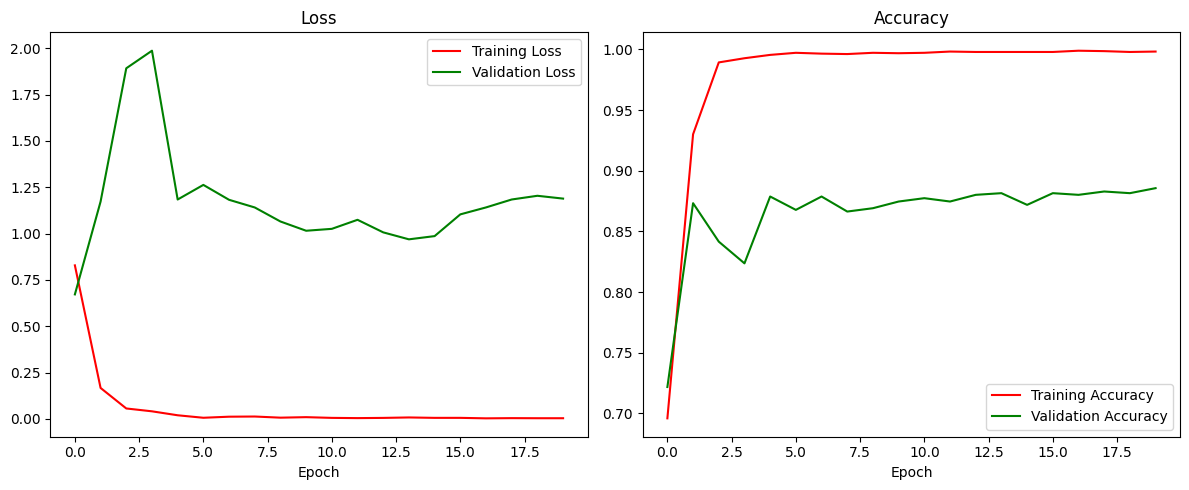

In [49]:
# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', c='red')
plt.plot(val_loss, label='Validation Loss', c='green')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy', c='red')
plt.plot(val_accuracy, label='Validation Accuracy', c='green')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Make predictions on the validation dataset
model_4_pred_probs = lstm4.predict(test_tweet)
display(model_4_pred_probs.shape, model_4_pred_probs[:10]) # view the first 10

model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds = np.argmax(model_4_preds, axis=1)

# Calculate LSTM model results
model_4_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_4_preds)
display(model_4_results)

display(tf.squeeze(tf.round(lstm4.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 3s 13ms/step


(726, 3)

array([[4.0729721e-03, 6.0336041e-01, 3.9256665e-01],
       [3.9492159e-05, 9.9960393e-01, 3.5668240e-04],
       [9.9999857e-01, 1.3499548e-06, 1.2511531e-07],
       [5.1523916e-06, 9.9999487e-01, 5.2026810e-08],
       [3.1781893e-03, 9.9681854e-01, 3.1924999e-06],
       [6.8586354e-09, 1.0862889e-06, 9.9999893e-01],
       [1.1812940e-08, 1.0000000e+00, 5.7004792e-09],
       [2.8420262e-08, 1.0000000e+00, 8.3110091e-10],
       [5.1812038e-10, 2.1041786e-11, 1.0000000e+00],
       [5.8079436e-10, 1.0000000e+00, 2.0837845e-12]], dtype=float32)

{'accuracy': 88.56749311294766,
 'precision': 0.886845276962911,
 'recall': 0.8856749311294766,
 'f1': 0.8857970677284284}

1/1 [==============================] - 0s 72ms/step


array([0., 1., 0.], dtype=float32)

In [52]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm4.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 47ms/step


In [53]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe[:25])

,sentimen,predicted_sentimen,tweet
0,1,1,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi dan raja salman sepakat tingkatkan kerj...
2,0,0,kala tax amnesty hari prabowo sama sandiaga un...
3,1,1,gimana nih apa atas gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dr binatang minimal juta tu...
5,2,2,uang gaji kami prabowo sandiuno tidak akan kam...
6,1,1,capres jokowi nasabah usaha mikro di pesantren...
7,1,1,demokrat minta prabowo hargai bantuan presiden...
8,1,2,orang baik jelas islamnya baju putih kekompaka...
9,1,1,ps bolakbalik menyinggung bertanya deindustria...


# Model 5

In [54]:
from keras.callbacks import EarlyStopping

In [55]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=64, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

In [60]:
def model5():

  inputs = layers.Input(shape=(1,), dtype="string")
  x = text_vectorizer(inputs)
  layer = embedding(x)
  layer = layers.LSTM(256, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(128, activation='relu', return_sequences=True)(layer)
  layer = layers.LSTM(64, activation='relu')(layer)
  # layer = layers.Dense(32, name='FC1')(layer)
  # layer = layers.Dense(16,)(layer)
  # layer = layers.Dense(8,)(layer)
  # layer = layers.Dense(4,)(layer)
  layer = layers.Activation('relu')(layer)
  layer = layers.Dropout(0.5)(layer)
  layer = layers.Dense(3, name='out_layer')(layer)
  layer = layers.Activation('softmax')(layer)
  model = tf.keras.Model(inputs=inputs, outputs=layer)
  return model

In [61]:
lstm5 = model5()
lstm5.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
lstm5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 24, 64)            640000    
                                                                 
 lstm_7 (LSTM)               (None, 24, 256)           328704    
                                                                 
 lstm_8 (LSTM)               (None, 24, 128)           197120    
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                           

In [62]:
lstm5_history = lstm5.fit(X_train, np.float32(Y_train),
                          epochs=20, # 20
                          batch_size=256, # 256
                          # callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)],
                          validation_data=(X_test, np.float32(Y_test)),)

Epoch 1/20


12/12 [==============================] - 36s 2s/step - loss: 1.0689 - accuracy: 0.4838 - val_loss: 0.9110 - val_accuracy: 0.5220
Epoch 2/20
12/12 [==============================] - 13s 1s/step - loss: 0.5546 - accuracy: 0.7979 - val_loss: 1.0080 - val_accuracy: 0.7493
Epoch 3/20
12/12 [==============================] - 13s 1s/step - loss: 0.2867 - accuracy: 0.9156 - val_loss: 1.8468 - val_accuracy: 0.7452
Epoch 4/20
12/12 [==============================] - 12s 1s/step - loss: 0.2049 - accuracy: 0.9428 - val_loss: 1.6273 - val_accuracy: 0.7562
Epoch 5/20
12/12 [==============================] - 15s 1s/step - loss: 0.1685 - accuracy: 0.9508 - val_loss: 1.2645 - val_accuracy: 0.7672
Epoch 6/20
12/12 [==============================] - 14s 1s/step - loss: 0.1182 - accuracy: 0.9652 - val_loss: 1.5022 - val_accuracy: 0.7824
Epoch 7/20
12/12 [==============================] - 12s 978ms/step - loss: 0.1079 - accuracy: 0.9697 - val_loss: 1.0958 - val_accuracy: 0.7934
Epoch 8/20
12/12 [==========

In [63]:
# Make predictions on the validation dataset
model_5_pred_probs = lstm5.predict(test_tweet)
display(model_5_pred_probs.shape, model_5_pred_probs[:10]) # view the first 10

model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds = np.argmax(model_5_preds, axis=1)

# Calculate LSTM model results
model_5_results = calculate_results(y_true=test_sentimen,
                                    y_pred=model_5_preds)
display(model_5_results)

display(tf.squeeze(tf.round(lstm5.predict(np.array(['Pak @sandiuno dan pak @prabowo Gajinya kirim ke saya sj'])))).numpy())

23/23 [==============================] - 6s 130ms/step


(726, 3)

array([[2.9805664e-05, 1.1089874e-04, 9.9985933e-01],
       [4.7342148e-02, 8.1747979e-01, 1.3517807e-01],
       [9.6242511e-01, 6.7179604e-04, 3.6903191e-02],
       [6.7832298e-07, 9.9997663e-01, 2.2634616e-05],
       [1.4966553e-02, 9.1249126e-01, 7.2542183e-02],
       [3.5425049e-10, 1.0407960e-11, 1.0000000e+00],
       [1.3061219e-24, 1.0000000e+00, 3.3869781e-19],
       [0.0000000e+00, 1.0000000e+00, 3.3730093e-37],
       [6.7671988e-04, 9.8636401e-06, 9.9931347e-01],
       [5.4941714e-11, 1.0000000e+00, 2.1986246e-08]], dtype=float32)

{'accuracy': 82.5068870523416,
 'precision': 0.8303398740101768,
 'recall': 0.8250688705234159,
 'f1': 0.8253900492648548}

1/1 [==============================] - 0s 71ms/step


array([0., 1., 0.], dtype=float32)

In [157]:
predicted_sentiment = []

for idx in range(len(test_tweet)):
  predicted = tf.squeeze(tf.round(lstm5.predict(np.array([test_tweet[idx]])))).numpy()
  predicted_sentiment.append(predicted)

1/1 [==============================] - 0s 70ms/step


In [158]:
predicted_dataframe['sentimen'] = test_sentimen
predicted_dataframe['predicted_sentimen'] = [np.argmax(array) for array in predicted_sentiment]
predicted_dataframe['tweet'] = test_tweet

display(predicted_dataframe)

,sentimen,predicted_sentimen,tweet
0,1,1,mau tanya impact buat negara kek gimana kalo g...
1,1,1,jokowi raja salman sepakat tingkat kerja sama ...
2,0,0,kala tax amnesty kemarin prabowo sama sandiaga...
3,1,1,gimana nih apa gaji tidak jokowi prabowo
4,1,1,beranganangan gaji dokter binatang minimal jut...
...,...,...,...
721,0,0,nyerocos gurubesar sumitro joyohadikusumo ekon...
722,1,1,asosiasi usaha bumiputera nusantara se indones...
723,0,0,tidak masuk otak lu bapak jokowi nanya ekonomi...
724,0,0,eh abang beda startup monetizing hobi monetize...


# Random Forest

In [159]:
rfc = RandomForestClassifier()

In [161]:
X_vect = text_vectorizer(X_train)
X_embedd = embedding(X_vect)

In [163]:
rfc.fit(X_vect, np.float32(Y_train))

RandomForestClassifier()

In [165]:
XT_vect = text_vectorizer(X_test)
rfc_score = rfc.score(XT_vect, np.float32(Y_test))
print(rfc_score)

0.8636363636363636


In [166]:
from sklearn.metrics import classification_report

In [167]:
y_pred = rfc.predict(XT_vect)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87       242
           1       0.87      0.87      0.87       256
           2       0.84      0.85      0.84       228

    accuracy                           0.86       726
   macro avg       0.86      0.86      0.86       726
weighted avg       0.86      0.86      0.86       726

